In [1]:
import warnings

warnings.filterwarnings("ignore")

import ast
import itertools
import json
import math
import os
import random
import re
import sys
from collections import Counter, deque
from copy import deepcopy
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
from rich import print
from scipy.signal import convolve2d
from tqdm import tqdm

In [2]:
def plot_mtx(mtx, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(mtx, cmap=plt.cm.Blues)
    plt.plot()

In [3]:
def read_file_to_str_li(fp, print_exp=True):
    with open(fp, "r") as f:
        lines = f.read().split("\n")
    if print_exp:
        print(f"Read from {fp}:")
        print(f"First line: {lines[0]} | Last line: {lines[-1]}")
        print("-" * 6)

    return lines


# define the function blocks
def convert_to_int(input_str):
    if input_str == "" or input_str == " ":
        return None
    return int(input_str)


def convert_to_str(input_str):
    return str(input_str)


# map the inputs to the function blocks
converts = {
    "i": convert_to_int,
    "s": convert_to_str,
}


def convert_str_li_to_other_li(
    str_li, pattern="i", per_letter=False, sep=" ", start_row=0, end_row=None
):
    """Convert a list of string to a list of other types

    pattern: a list of types for one item.
        'i' for int, 's' for string
        'si' means: convert the 1st item to string, the rest to integer
        If separated items are more than pattern items,
        use the last one from the parttern.
    if per_letter=True, ignore sep and separate item per letter
    """
    target_str_li = str_li[start_row:end_row]
    # find max item num
    max_item_num = 1
    if per_letter:
        max_item_num = max([len(s) for s in target_str_li])
    else:
        max_item_num = max([len(s.split(sep)) for s in target_str_li])

    # extend the pattern to the max itme num
    pattern = (
        pattern + f"{pattern[-1]}" * (max_item_num - len(pattern))
        if max_item_num > len(pattern)
        else pattern
    )

    # convert
    if per_letter:
        return [
            [converts[pattern[idx]](item) for idx, item in enumerate(s)]
            for s in target_str_li
        ]
    else:
        if sep == " ":
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split())]
                for s in target_str_li
            ]
        else:
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split(sep))]
                for s in target_str_li
            ]

In [4]:
fp = "input.txt"
lines = read_file_to_str_li(fp)

print("Convert to:")

# head = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=True, sep=",", start_row=0, end_row=1
# )

# print(f"Head:\n{head}")
# print(f"First line: {head[0]}")
# print(f"Last line: {head[-1]}")

data = convert_str_li_to_other_li(
    lines, pattern="s", per_letter=True, sep=" ", start_row=None, end_row=None
)


print(f"First line: {data[0]}")
print(f"Last line: {data[-1]}")
print("-" * 6)

Read from input.txt:

First line: 
#.#################################################################################################################
####### | Last line: 
###################################################################################################################
#####.#

------

Convert to:

First line: ['#', '.', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#']

Last line: ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 
'#', '#', '#', '#', '#', '#', '#', '#', '.', '#']

------

25 120

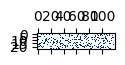

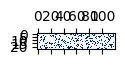

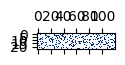

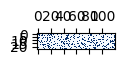

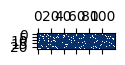

In [5]:
mtx = np.array(data)[1:-1, 1:-1]
h, w = mtx.shape
print(h, w)
blizzard_north = np.zeros_like(mtx, dtype="int")
blizzard_north[np.where(mtx == "^")] = 1
plot_mtx(blizzard_north, (1, 1))
blizzard_south = np.zeros_like(mtx, dtype="int")
blizzard_south[np.where(mtx == "v")] = 1
plot_mtx(blizzard_south, (1, 1))
blizzard_west = np.zeros_like(mtx, dtype="int")
blizzard_west[np.where(mtx == "<")] = 1
plot_mtx(blizzard_west, (1, 1))
blizzard_east = np.zeros_like(mtx, dtype="int")
blizzard_east[np.where(mtx == ">")] = 1
plot_mtx(blizzard_east, (1, 1))

blizzards = blizzard_north | blizzard_south | blizzard_west | blizzard_east
plot_mtx(blizzards, (1, 1))

In [6]:
def find_possible_pos(blizzards):
    pos_dict = {}
    for i in range(blizzards.shape[0]):
        for j in range(blizzards.shape[1]):
            possible_pos = []
            for pos in [(i, j), (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]:
                if (
                    (0 <= pos[0] <= h - 1)
                    and (0 <= pos[1] <= w - 1)
                    and (blizzards[pos] == 0)
                ):
                    possible_pos.append(pos)
            pos_dict[(i, j)] = possible_pos
    return pos_dict

In [7]:
blank_pos_li = []
loop_num = np.lcm(w, h)
for _ in tqdm(range(loop_num)):
    blizzard_north = np.r_[blizzard_north[1:, :], blizzard_north[:1, :]]
    blizzard_south = np.r_[blizzard_south[-1:, :], blizzard_south[:-1, :]]
    blizzard_west = np.c_[blizzard_west[:, 1:], blizzard_west[:, 0]]
    blizzard_east = np.c_[blizzard_east[:, -1], blizzard_east[:, :-1]]

    blizzards = blizzard_north | blizzard_south | blizzard_west | blizzard_east
    blank_pos_li.append(find_possible_pos(blizzards))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 193.03it/s]


In [8]:
def find_next_enter_step(pos, start_step):
    while True:
        if pos in blank_pos_li[start_step % loop_num][pos]:
            break
        start_step += 1
    return start_step


def count_steps(start_p, end_p, start_step):
    flag = True
    while flag:
        # Count steps to enter
        start_step = find_next_enter_step(start_p, start_step)
        current_step = start_step + 1
        pre_reached_pos = [start_p]
        while True:
            new_reached_pos = []
            for pos in pre_reached_pos:
                new_reached_pos.extend(blank_pos_li[current_step % loop_num][pos])
            pre_reached_pos = list(set(new_reached_pos))
            if len(pre_reached_pos) == 0:
                flag = True
                break
            if end_p in pre_reached_pos:
                flag = False
                break
            current_step += 1
        start_step += 1
    return current_step

In [9]:
%%time
# GO
start_step = 0
start_p = (0, 0)
end_p = (h - 1, w - 1)
current_step = count_steps(start_p, end_p, start_step)
print(f"Answer to Q1: {current_step + 2}")

# GO BACK
start_step = current_step + 1
start_p = (h - 1, w - 1)
end_p = (0, 0)
current_step = count_steps(start_p, end_p, start_step)

# GO AGAIN
start_step = current_step + 1
start_p = (0, 0)
end_p = (h - 1, w - 1)
current_step = count_steps(start_p, end_p, start_step)
print(f"Answer to Q2: {current_step + 2}")

Answer to Q1: 283

Answer to Q2: 883

CPU times: user 120 ms, sys: 3.09 ms, total: 123 ms
Wall time: 122 ms
